In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
import asyncio
from concurrent.futures import ThreadPoolExecutor
import os
from groq import Groq
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import json
from langgraph.graph import Graph, StateGraph, END, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import logging
from typing import Dict, Any
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from datetime import date
from dotenv import load_dotenv
from typing import Optional, List
from pydantic import BaseModel
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(
    model= "deepseek-r1-distill-llama-70b",  #"openai/gpt-oss-120b", #"gemma2-9b-it", #
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [4]:
from pydantic import BaseModel, Field

class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description="Column name for transaction date")
    debit: str = Field(..., description="Column name for debit amount")
    credit: str = Field(..., description="Column name for credit amount")

In [5]:
class BankReconciliationState(BaseModel):
    bank_data: str
    erp_data: str
    bank_columns: Optional[ColumnSchema] = None
    erp_columns: Optional[ColumnSchema] = None
    bank_chunk_data: Optional[List[pd.DataFrame]] = None
    erp_chunk_data: Optional[List[pd.DataFrame]] = None
    erp_chunk_amount: Optional[dict] = None
    bank_chunk_amount: Optional[dict] = None

    model_config = {
        "arbitrary_types_allowed": True  # << this allows pd.DataFrame
    }


In [6]:
structured_model_column = llm.with_structured_output(ColumnSchema)

In [7]:
# Reusable function for detecting columns
def detect_columns(file_path: str):
    df = pd.read_csv(file_path)
    subset_data = df.head(5)
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """
    return structured_model_column.invoke(prompt)


# Node: find columns in bank dataset
def find_bank_columns(state: BankReconciliationState):
    result = detect_columns(state.bank_data)
    return {"bank_columns": result}


# Node: find columns in ERP dataset
def find_erp_columns(state: BankReconciliationState):
    result = detect_columns(state.erp_data)
    return {"erp_columns": result}



In [8]:
import pandas as pd

def chunk_dataset(state: BankReconciliationState):
    """
    Split both datasets into chunks of up to 3 days each.
    Keep only 'transaction_date', 'debit', 'credit' columns in state data.
    """

    bank_date_column = state.bank_columns.transaction_date
    erp_date_column = state.erp_columns.transaction_date

    # Load datasets
    bank_df = pd.read_csv(state.bank_data)
    erp_df = pd.read_csv(state.erp_data)

    # Ensure transaction_date is datetime
    bank_df[bank_date_column] = pd.to_datetime(bank_df[bank_date_column], errors="coerce")
    erp_df[erp_date_column] = pd.to_datetime(erp_df[erp_date_column], errors="coerce")

    # Drop invalid dates
    bank_df = bank_df.dropna(subset=[bank_date_column])
    erp_df = erp_df.dropna(subset=[erp_date_column])

    # Helper function to chunk by 3-day windows
    def split_by_days(df, date_column):
        if df.empty:
            return []
        df = df.sort_values(by=date_column).reset_index(drop=True)
        min_date, max_date = df[date_column].min(), df[date_column].max()

        if (max_date - min_date).days < 2:
            return [df]

        chunks = []
        start_date = min_date
        while start_date <= max_date:
            end_date = start_date + pd.Timedelta(days=1)
            chunk = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
            if not chunk.empty:
                chunks.append(chunk.reset_index(drop=True))
            start_date = end_date + pd.Timedelta(days=1)
        return chunks

    # Split datasets
    bank_chunks = split_by_days(bank_df, bank_date_column)
    erp_chunks = split_by_days(erp_df, erp_date_column)

    # Ensure both have the same number of chunks (pad smaller with empty DataFrames)
    max_chunks = max(len(bank_chunks), len(erp_chunks))
    while len(bank_chunks) < max_chunks:
        bank_chunks.append(pd.DataFrame(columns=bank_df.columns))
    while len(erp_chunks) < max_chunks:
        erp_chunks.append(pd.DataFrame(columns=erp_df.columns))

    # ✅ Keep only required columns in each chunk
    required_cols = [bank_date_column, state.bank_columns.debit, state.bank_columns.credit]
    state.bank_chunk_data = [chunk[required_cols].copy() for chunk in bank_chunks]
    state.erp_chunk_data = [chunk[[erp_date_column, state.erp_columns.debit, state.erp_columns.credit]].copy() for chunk in erp_chunks]

    return {
        "bank_chunk_data": state.bank_chunk_data,
        "erp_chunk_data": state.erp_chunk_data
    }


In [9]:
def reconciliations(state: BankReconciliationState):
    """LLM-powered reconciliation function that generates Python code for calculations."""
    import pandas as pd
    import re
    
    # Take first chunk of each dataset
    bank_df = state.bank_chunk_data[5]
    erp_df = state.erp_chunk_data[5]
    
    # Extract dynamic column names from state
    bank_transaction_date = state.bank_columns.transaction_date
    bank_credit = state.bank_columns.credit
    bank_debit = state.bank_columns.debit
    erp_transaction_date = state.erp_columns.transaction_date
    erp_credit = state.erp_columns.credit
    erp_debit = state.erp_columns.debit
    
    # Create a detailed prompt for the LLM to generate Python code
    bank_sample = bank_df.head(5).to_string() if not bank_df.empty else "No data"
    erp_sample = erp_df.head(5).to_string() if not erp_df.empty else "No data"
    
    prompt = f"""You are a financial analyst. Write Python code to calculate net balance for two datasets.

Bank dataset columns:
- Transaction date: "{bank_transaction_date}"
- Debit: "{bank_debit}" 
- Credit: "{bank_credit}"

ERP dataset columns:
- Transaction date: "{erp_transaction_date}"
- Debit: "{erp_debit}"
- Credit: "{erp_credit}"

Sample bank data:
{bank_sample}

Sample ERP data:
{erp_sample}

Task: Write Python code to calculate net balance for bank dataset is (total_credit - total_debit) and net balance for erp dataset is (total_debit - total_credit).

Requirements:
1. Convert columns to numeric, handling commas and NaN values as 0
2. Calculate: bank_net_balance = bank_total_credit - bank_total_debit
3. Calculate: erp_net_balance = erp_total_debit - erp_total_credit 
4. Use the exact column names provided above
5. Return only executable Python code, no explanations or markdown

Example format:
# Clean bank data
bank_df['{bank_credit}'] = pd.to_numeric(bank_df['{bank_credit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
bank_df['{bank_debit}'] = pd.to_numeric(bank_df['{bank_debit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
bank_total_credit = bank_df['{bank_credit}'].sum()
bank_total_debit = bank_df['{bank_debit}'].sum()
bank_net_balance = bank_total_credit - bank_total_debit

# Clean ERP data
erp_df['{erp_credit}'] = pd.to_numeric(erp_df['{erp_credit}'], errors='coerce').fillna(0)
erp_df['{erp_debit}'] = pd.to_numeric(erp_df['{erp_debit}'], errors='coerce').fillna(0)
erp_total_credit = erp_df['{erp_credit}'].sum()
erp_total_debit = erp_df['{erp_debit}'].sum()
erp_net_balance = erp_total_debit - erp_total_credit"""
    
    try:
        # Use regular LLM instead of structured output to avoid tool choice errors
        from langchain_core.messages import HumanMessage
        response = llm.invoke([HumanMessage(content=prompt)])
        code = response.content
        
        # Clean the response (remove markdown code blocks if present)
        code = re.sub(r'```python\n?', '', code)
        code = re.sub(r'\n?```', '', code)
        code = code.strip()
        
        print(f"🤖 LLM Generated Reconciliation Code:")
        print(code)
        print("=" * 50)
        
        # Execute the LLM-generated code in a safe scope
        local_vars = {"bank_df": bank_df.copy(), "erp_df": erp_df.copy(), "pd": pd}
        exec(code, {"pd": pd}, local_vars)
        
        # Extract variables from executed code
        bank_net_balance = local_vars.get("bank_net_balance")
        erp_net_balance = local_vars.get("erp_net_balance")
        
        if bank_net_balance is None or erp_net_balance is None:
            raise ValueError("LLM code did not produce required variables")
        
        # Save results in state
        state.bank_chunk_amount = bank_net_balance
        state.erp_chunk_amount = erp_net_balance
        
        print(f"💰 LLM Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
        
    except Exception as e:
        print(f"⚠️ LLM calculation failed: {e}")
        print("🔄 Falling back to hardcoded calculation...")
        
        # Fallback to hardcoded calculation if LLM fails
        bank_df[bank_credit] = pd.to_numeric(bank_df[bank_credit].astype(str).str.replace(',', '').replace('nan', '0'), errors='coerce').fillna(0)
        bank_df[bank_debit] = pd.to_numeric(bank_df[bank_debit].astype(str).str.replace(',', '').replace('nan', '0'), errors='coerce').fillna(0)
        bank_total_credit = bank_df[bank_credit].sum()
        bank_total_debit = bank_df[bank_debit].sum()
        bank_net_balance = bank_total_credit - bank_total_debit
        
        erp_df[erp_credit] = pd.to_numeric(erp_df[erp_credit], errors='coerce').fillna(0)
        erp_df[erp_debit] = pd.to_numeric(erp_df[erp_debit], errors='coerce').fillna(0)
        erp_total_credit = erp_df[erp_credit].sum()
        erp_total_debit = erp_df[erp_debit].sum()
        erp_net_balance = erp_total_debit - erp_total_credit
        
        state.bank_chunk_amount = bank_net_balance
        state.erp_chunk_amount = erp_net_balance
        
        print(f"💰 Fallback Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
    
    return state

print("✅ Helper functions defined")


✅ Helper functions defined


In [10]:

# Build workflow
print("\n🔧 Building workflow...")
graph = StateGraph(BankReconciliationState)

# Add nodes
graph.add_node("find_bank_columns", find_bank_columns)
graph.add_node("find_erp_columns", find_erp_columns)
graph.add_node("chunk_dataset", chunk_dataset)
graph.add_node("reconciliations", reconciliations)

# Connect edges
graph.add_edge(START, "find_bank_columns")
graph.add_edge(START, "find_erp_columns")
graph.add_edge("find_bank_columns", "chunk_dataset")
graph.add_edge("find_erp_columns", "chunk_dataset")
graph.add_edge("chunk_dataset", "reconciliations")
graph.add_edge("reconciliations", END)

# Compile workflow
workflow = graph.compile()
print("✅ Workflow built and compiled")



🔧 Building workflow...
✅ Workflow built and compiled


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:57393/devtools/browser/99a7d898-28ca-4b46-a4c6-4bc5cf89bd0b
INFO:pyppeteer.launcher:terminate chrome process...


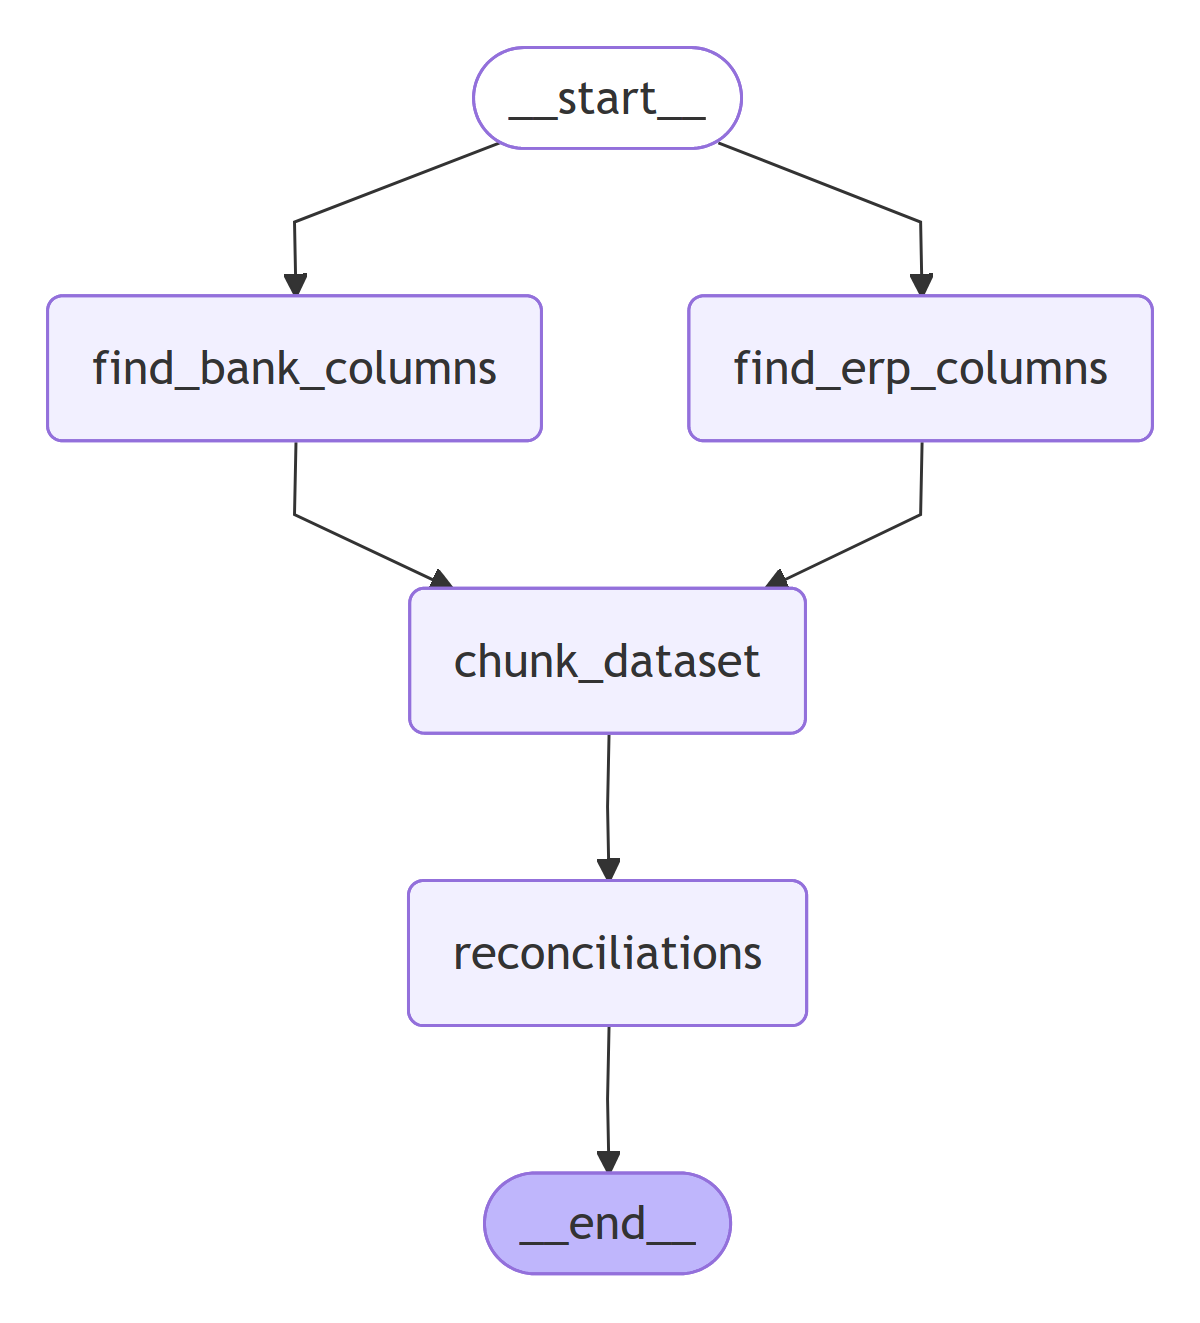

In [11]:
# from IPython.display import Image, display
# Image(workflow.get_graph().draw_mermaid_png())


import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()  # patch the running event loop

# Render workflow graph locally
png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))


In [12]:
initial_state = {
    "erp_data": "Dataset/Pubali # 41774-ERP.csv",
    "bank_data": "Dataset/Pubali # 41774.csv"
}

try:
    result = workflow.invoke(initial_state)
    print("✅ Workflow executed successfully")
    
    print("\n📋 Results:")
    print("Bank Columns:", result["bank_columns"])
    print("ERP Columns:", result["erp_columns"])
    
    bank_columns = result["bank_columns"]
    erp_columns = result["erp_columns"]
    
    print(f"\n🏦 Bank columns - Date: {bank_columns.transaction_date}, Debit: {bank_columns.debit}, Credit: {bank_columns.credit}")
    print(f"🏢 ERP columns - Date: {erp_columns.transaction_date}, Debit: {erp_columns.debit}, Credit: {erp_columns.credit}")
    
    print(f"\nBank chunk amount: {result['bank_chunk_amount']}")
    print(f"ERP chunk amount: {result['erp_chunk_amount']}")
    
except Exception as e:
    print(f"❌ Error running workflow: {e}")
    import traceback
    traceback.print_exc()


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🤖 LLM Generated Reconciliation Code:
<think>
Okay, so I need to write Python code to calculate the net balance for two datasets: one from the bank and one from ERP. The user has given me specific instructions, so I should follow them carefully.

First, I'll look at the bank dataset. The columns are "TRN DATE", "DEBIT", and "CREDIT". The net balance for the bank is calculated as total credit minus total debit. The sample data shows that the DEBIT column has NaN values, which I need to handle by converting them to 0. Also, the credit values have commas, like "20,000.00", so I need to remove those commas before converting to numeric.

For the ERP dataset, the columns are "Date", "Debit", and "Credit". Here, the net balance is total debit minus total credit. The sample data doesn't show any commas, but I should still handle any possible non-numeric values by converting them to 0.

I'll start by importing pandas as pd because I'll need it for data manipulation. Then, I'll read the bank and 

In [16]:
len(result["bank_chunk_data"])

16

In [17]:
result["bank_chunk_data"][0]

,TRN DATE,DEBIT,CREDIT
0,2025-02-07,NaN,"16,000.00"
1,2025-02-07,NaN,"16,000.00"
2,2025-02-07,NaN,"20,000.00"
3,2025-02-07,NaN,"100,000.00"
4,2025-02-07,NaN,"30,000.00"
...,...,...,...
83,2025-02-07,NaN,"10,000.00"
84,2025-02-07,NaN,"5,000.00"
85,2025-02-07,NaN,"50,000.00"
86,2025-02-07,NaN,"114,500.00"


In [18]:
result["erp_chunk_data"][0]

,Date,Debit,Credit
0,2025-07-01,6160.0,NaN
1,2025-07-01,11000.0,NaN
2,2025-07-02,50000.0,NaN
3,2025-07-02,8000.0,NaN
4,2025-07-02,20000.0,NaN
...,...,...,...
83,2025-07-02,70000.0,NaN
84,2025-07-02,6000.0,NaN
85,2025-07-02,29700.0,NaN
86,2025-07-02,30000.0,NaN


In [20]:
df = pd.DataFrame(result["bank_chunk_data"][5])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["CREDIT"] = (
    df["CREDIT"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["CREDIT"].sum()

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["DEBIT"] = (
    df["DEBIT"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_DEBIT = df["DEBIT"].sum()

print(total_credit - total_DEBIT)

-391440.0


In [21]:
df = pd.DataFrame(result["erp_chunk_data"][5])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Credit"] = (
    df["Credit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["Credit"].sum()

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Debit"] = (
    df["Debit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_Debit = df["Debit"].sum()

print(total_Debit-total_credit)

440875.0
